In [1]:
import json, os, sys, numbers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
sys.path.append("../scripts/")
from collections import defaultdict, Counter
from pprint import pprint
from helper import *

In [2]:
import json
test = open("../data/lila/multi/iid/test.json", "r").readlines()
print(len(test))
pprint(json.loads(test[0]))

31365
{'Input': 'Which is the biggest value?  (a) 0  (b) -3/49  (c) 370  (d) 0.3',
 'Output Answer': ['370'],
 'Output Program': ['from sympy import *\n'
                    'choices = [0, -3/49, 370, 0.3]\n'
                    'print(sorted(choices, reverse=True)[0])'],
 'dataset': 'deepmind_mathematics_basicmath.json',
 'dist': 'iid',
 'split': 'test',
 'text': 'Question: Which is the biggest value?  (a) 0  (b) -3/49  (c) 370  '
         '(d) 0.3\n'
         '\n'
         'Answer: 370\n'
         '\n'
         'Program:\n'
         '```python\n'
         'from sympy import *\n'
         'choices = [0, -3/49, 370, 0.3]\n'
         'print(sorted(choices, reverse=True)[0])\n'
         '```'}


In [3]:
def rel_error(pred, gth, abs_err=False):
    pred, gth = float(pred), float(gth)
    if gth == 0: res = pred-gth
    else: res = (pred - gth) / np.absolute(gth)
    if abs_err: res = np.absolute(res)
    return res

In [4]:
results = pd.read_csv(
    "../data/lila/results/vicuna-13b/iid_test_single_ans.csv", 
    header=0, 
    keep_default_na=False # prevent from reading empty strings as nan
)

print(len(results))
results.head(5)

5342


,id,gth_ans,output_dir_ans,dir_ans_em,exec_ans,exec_ans_em,output_dir_ans_without_program,dir_ans_without_program_em
0,0,370.000000,37.0,0,(a) is the biggest value,0,370,1
1,1,-5.000000,0.5300000000000001,0,-3.4,0,w,0
2,2,0.004494,0.2,0,-0.2222222222222222,0,0.2,0
3,3,0.000000,-0.13,0,NameError,0,-0.13,0
4,4,1.020000,1.02,1,SyntaxError,0,-0.463768115942029,0


In [9]:
rel_errors = {
    "dir": [],
    "guess_program": [],
    "exec": []
}
abs_err = True
for i in range(len(results)):
    d = results.loc[i].to_dict()
    gth = d['gth_ans']
    x = d["id"]
    try:
        pred = float(d["output_dir_ans_without_program"])
        rel_errors["dir"].append(rel_error(pred, gth, abs_err))
    except: pass
    try:
        pred = float(d["output_dir_ans"])
        rel_errors["guess_program"].append(rel_error(pred, gth, abs_err))
    except: pass
    try:
        pred = float(d["exec_ans"])
        rel_errors["exec"].append(rel_error(pred, gth, abs_err))
    except: pass
    
for k, v in rel_errors.items():
    print(k, len(v))

dir 4876
guess_program 4853
exec 4185


dir 3885
guess_program 4002
exec 3132


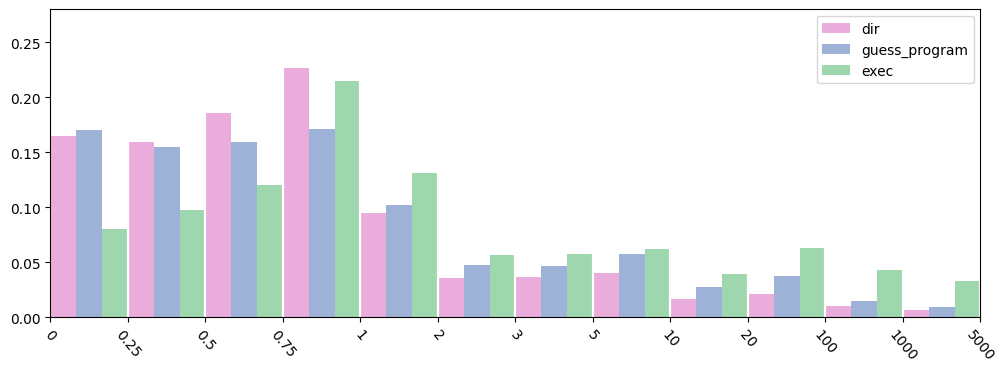

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
colors = iter(['#D65CB8', '#3E64AF', '#3EAF5D'])
bar_types = 3
ticks = [
            0,
            0.25, 0.5, 0.75, 1, 2, 3, 5, 10,
            20, 100, 1000, 5000
        ]
for i, k in enumerate(rel_errors.keys()):
    v = rel_errors[k]
    
    values = [_v for _v in v if not -0.001 < _v < 0.001]
    print(k, len(values))    
    bins = [np.min(values)] + ticks[1:-1] + [np.max(values)]
    frq, edges = np.histogram(values, bins=bins)
    edges = [0] + list(edges)[1:-1] + [ticks[-1]]

    edges_ = [0]
    frq_ = [0]
    prev_e = 0
    for f, e in zip(frq, list(range(1, len(edges)))): 
        edges_.extend([
            prev_e + i/bar_types,
            prev_e + (i+1)/bar_types
        ])
        frq_.extend([f/len(values), 0])
        prev_e = e
    edges_.append(edges[-1])

    ax.stairs(frq_, edges_, fill=True, color=next(colors), alpha=0.5, label=k)
    ax.vlines(list(range(len(ticks))), 0, frq.max(), colors='w')
plt.ylim((0, 0.28))
plt.xlim((0, len(ticks)-1))
plt.xticks(list(range(len(ticks))), ticks, rotation=310)
plt.legend()
plt.show()



In [5]:
iid_test = [json.loads(l) for l in open("../data/lila/multi/iid/test.json", "r").readlines()]
tmp = json.load(open("../data/lila/single_number_ans_ids.json", "r"))
iid_selected_ids = tmp['iid_test']

In [27]:
c = Counter()
for x in iid_selected_ids:
    #length = len(iid_test[x]['Input'].strip()) // 30
    gth = float(iid_test[x]['Output Answer'][0])
    if not gth == 0:
        gth = int(np.log10(np.abs(gth))) + 1
    c[gth] += 1
c


Counter({3: 885,
         1: 1585,
         -1: 7,
         0.0: 56,
         9: 4,
         6: 26,
         2: 2412,
         5: 88,
         7: 7,
         4: 263,
         12: 1,
         -5: 1,
         8: 4,
         -4: 2,
         -2: 1})

In [19]:
EM = defaultdict(list)
RELERROR = defaultdict(list)
max_rel_error = 5000
for i in range(len(results)):
    d = results.loc[i].to_dict()
    gth = d['gth_ans']
    x = d["id"]
    number_count = len(count_numbers_in_str(iid_test[x]['Input']))
    if number_count > 10: number_count = 11
    EM[number_count].append(int(d["exec_ans_em"]))
    try: 
        pred = float(d["exec_ans"])
        e = min(max_rel_error, rel_error(pred, gth, abs_err=True))
        RELERROR[number_count].append(e)
    except:
        pass #e = max_rel_error
    

print("Diffculty measure: number count in question")
print("{:10} {:10} {:10} {:12}".format("Difficulty", "#questions", "avg EM", "avg rel_error"))
for k in range(12):
    print("{:6} {:12} {:10.6f} {:12.6f}".format(k, len(EM[k]), np.mean(EM[k]), np.mean(RELERROR[k])))


Diffculty measure: number count in question
Difficulty #questions avg EM     avg rel_error
     0          199   0.341709    12.123951
     1          373   0.128686   130.050118
     2         1643   0.359099    63.861246
     3         1458   0.168724   114.971864
     4          746   0.099196   158.358117
     5          365   0.073973   147.438065
     6          245   0.044898   157.748814
     7          111   0.027027    42.028699
     8           57   0.035088    62.138121
     9           48   0.062500    38.085920
    10           30   0.033333  1004.792556
    11           67   0.044776    81.205901


In [16]:
EM = defaultdict(list)
RELERROR = defaultdict(list)
bin_width = 30
max_rel_error = 5000
for i in range(len(results)):
    d = results.loc[i].to_dict()
    gth = d['gth_ans']
    x = d["id"]
    length = len(iid_test[x]['Input'].strip()) // bin_width
    if length > 10: length = 11
    EM[length].append(int(d["dir_ans_without_program_em"]))

    try: 
        pred = float(d["output_dir_ans_without_program"])
        e = min(max_rel_error, rel_error(pred, gth, abs_err=True))
        RELERROR[length].append(e)
    except:
        pass #e = max_rel_error
    

print("Diffculty measure: question length")
print("{:10} {:10} {:10} {:12}".format("Difficulty", "#questions", "avg EM", "avg rel_error"))
for k in range(12):
    print("{:10} {:8} {:10.6f} {:12.6f}".format(
        f"{str(k*bin_width)}-{str((1+k)*bin_width)}", 
        len(EM[k]), 
        np.mean(EM[k]), 
        np.mean(RELERROR[k])
    ))

Diffculty measure: question length
Difficulty #questions avg EM     avg rel_error
0-30             88   0.204545    19.540137
30-60           491   0.112016   117.348363
60-90           436   0.346330    75.935837
90-120          841   0.334126     9.613641
120-150         884   0.227376     3.349257
150-180         761   0.172142     8.956646
180-210         552   0.121377     1.965943
210-240         398   0.113065    16.622240
240-270         280   0.107143    21.789506
270-300         197   0.086294    30.209825
300-330         128   0.070312    15.888199
330-360         286   0.080420    11.512067


In [10]:
EM = defaultdict(list)
RELERROR = defaultdict(list)
max_rel_error = 5000
for i in range(len(results)):
    d = results.loc[i].to_dict()
    gth = d['gth_ans']
    x = d["id"]
    src_dataset = iid_test[x]['dataset'].split(".json")[0]
    EM[src_dataset].append(int(d["exec_ans_em"]))

    try: 
        pred = float(d["exec_ans"])
        e = min(max_rel_error, rel_error(pred, gth, abs_err=True))
        RELERROR[src_dataset].append(e)
    except:
        pass #e = max_rel_error
    

print("Diffculty measure: source dataset")
print("{:35} {:10} {:10} {:12}".format("src", "#questions", "avg EM", "avg rel_error"))
for k in EM.keys():
    print("{:35} {:8} {:10.6f} {:12.6f}".format(
        k, 
        len(EM[k]), 
        np.mean(EM[k]), 
        np.mean(RELERROR[k])
    ))

Diffculty measure: source dataset
src                                 #questions avg EM     avg rel_error
deepmind_mathematics_basicmath            90   0.244444   201.796605
mathqa_gain                              391   0.084399   281.366326
draw_structured                          200   0.010000    77.233604
mathqa_probability                        24   0.000000    31.679449
deepmind_mathematics_calculus             30   0.133333    94.611111
singleop                                 159   0.704403    27.034015
deepmind_mathematics_algebra             298   0.117450   327.437350
NumGLUE_Type_8_crowdsourced              175   0.400000    40.637433
mathqa_physics                           488   0.032787   205.314526
asdiv                                    614   0.431596    36.368987
simuleq                                  146   0.020548    66.904096
svamp_structured                         299   0.307692    11.673383
multiarith                               174   0.281609     4.7269

In [31]:
EM = defaultdict(list)
RELERROR = defaultdict(list)
max_rel_error = 5000
for i in range(len(results)):
    d = results.loc[i].to_dict()
    gth = d['gth_ans']
    x = d["id"]
    mag = float(iid_test[x]['Output Answer'][0])
    if not mag == 0:
        mag = int(np.log10(np.abs(mag))) + 1
    EM[mag].append(int(d["dir_ans_without_program_em"]))

    try: 
        pred = float(d["output_dir_ans_without_program"])
        e = min(max_rel_error, rel_error(pred, gth, abs_err=True))
        RELERROR[mag].append(e)
    except:
        pass #e = max_rel_error
    

print("Diffculty measure: magnitude of gth answer")
print("{:10} {:10} {:10} {:12}".format("Difficulty", "#questions", "avg EM", "avg rel_error"))
for k in sorted(list(EM.keys())):
    print("{:10} {:8} {:10.6f} {:12.6f}".format(
        k, 
        len(EM[k]), 
        np.mean(EM[k]), 
        np.mean(RELERROR[k])
    ))


Diffculty measure: magnitude of gth answer
Difficulty #questions avg EM     avg rel_error
        -5        1   0.000000   985.835041
        -4        2   0.000000    52.204554
        -2        1   0.000000   319.000000
        -1        7   0.142857    37.747706
       0.0       56   0.196429   155.642337
         1     1585   0.226498    45.977615
         2     2412   0.204809    14.660236
         3      885   0.133333     1.804107
         4      263   0.091255    23.977129
         5       88   0.102273     0.824256
         6       26   0.153846   239.152948
         7        7   0.428571     0.649393
         8        4   0.500000     2.986068
         9        4   0.500000  1250.423310
        12        1   1.000000     0.000000
